<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import torch 
import torch.nn.functional as F
from torch import nn
import scipy.io as io
import matplotlib.pyplot as plt

from torch.optim import SGD, Adam
from torch.utils import data

import time
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
k = 8### number of bits 
N_ch = 4 ### Number of complex channel use

N = 2 * N_ch ### number of (real) signal dimensions

R = k/N_ch # bits / 2 dims

M = 2**k
NN_T = 256
NN_R = 256

batch_size = 65536

In [3]:

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(M, NN_T)
        self.fc2 = nn.Linear(NN_T, NN_T)
        self.fc3 = nn.Linear(NN_T, 2*N_ch)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        tx = x / torch.sqrt(2 * torch.mean(x**2))
        return tx
            


        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2*N_ch, NN_R)  
        self.fc2 = nn.Linear(NN_R, NN_R) 
        self.fc3 = nn.Linear(NN_R, NN_R) 
        self.fc4 = nn.Linear(NN_R, M)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        decoded = F.log_softmax(x, dim=-1)
        return decoded
    
    
def awgn_interference_channel(x1, x2, sigma):
    y1 = x1 + x2 + (sigma * torch.randn(x1.shape)).to(device)
    y2 = x2 + x1 + (sigma * torch.randn(x1.shape)).to(device)
    return y1, y2




    


In [4]:
encoder1 = Encoder().to(device)
encoder2 = Encoder().to(device)

decoder1 = Decoder().to(device)
decoder2 = Decoder().to(device)

criterion= nn.NLLLoss()

params = list(encoder1.parameters()) + list(encoder2.parameters()) + list(decoder1.parameters())+ list(decoder2.parameters())
opt = Adam(params, lr = 1e-3)


In [5]:
### Load pre-trained Model

Path = 'AE_interference_channel'
checkpoint = torch.load(Path)
encoder1.load_state_dict(checkpoint['Encoder1'])
decoder1.load_state_dict(checkpoint['Decoder1'])
encoder2.load_state_dict(checkpoint['Encoder2'])
decoder2.load_state_dict(checkpoint['Decoder2'])



<All keys matched successfully>

In [6]:
if k == 4:
    EbNo_dB = 7 # training SNR
elif k == 8:
    EbNo_dB = 11
EbNo_r = 10**(EbNo_dB/10)
train_sigma = np.sqrt(1/(2*R*EbNo_r))

In [7]:

### uncommend this section to start training
####### training Phase,


# loss_sv1 = []
# loss_sv2= []

# gradient_steps= int(5e4)

# t = tqdm(range(len(range(gradient_steps))), desc="epoch")


# for III in t:

#     x1= (torch.arange(M).view(-1,1)).repeat(1,M).view(-1).to(device)
#     x2 = (torch.arange(M)).repeat(M).to(device)

#     x1 = x1.repeat(batch_size//(M*M))
#     x2 = x2.repeat(batch_size//(M*M))


#     one_hot1 = F.one_hot(x1, M).float()
#     one_hot2 = F.one_hot(x2, M).float()


#     tx1 = encoder1(one_hot1)
#     tx2 = encoder2(one_hot2)

#     rx1, rx2 = awgn_interference_channel(tx1, tx2, train_sigma)

#     y_pred1 = decoder1(rx1)
#     y_pred2 = decoder2(rx2)


#     loss1 = criterion(y_pred1, x1)
#     loss2 = criterion(y_pred2, x2)

#     alpha = loss1.item()/(loss1.item()+loss2.item())
#     loss = alpha*loss1 + (1-alpha)*loss2



#     opt.zero_grad()
#     loss.backward()

#     if III > 100==0:
#         torch.nn.utils.clip_grad_norm_(params, 0.005)
#     opt.step()


#     if III%10==0 or III==1:
#         t.set_description('iter {:5d}: L1 = {:.5f}, L2 = {:.5f}, alpha = {:.3f}'.format(III, loss1, loss2, alpha))
#         t.refresh() # to show immediately the update

#     loss_sv1.append(loss1.item())
#     loss_sv2.append(loss2.item())






iter    90: L1 = 0.00388, L2 = 0.00345, alpha = 0.530: 100%|██████████| 100/100 [00:05<00:00, 18.95it/s]


In [8]:
# print(torch.max(params[0]))

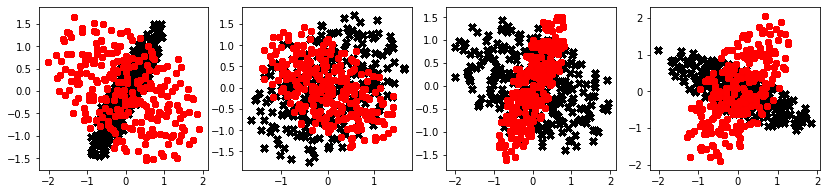

In [9]:

x1= (torch.arange(M).view(-1,1)).repeat(1,M).view(-1).to(device)
x2 = (torch.arange(M)).repeat(M).to(device)

x1 = x1.repeat(batch_size//(M*M))
x2 = x2.repeat(batch_size//(M*M))

one_hot1 = F.one_hot(x1, M).float()
one_hot2 = F.one_hot(x2, M).float()


tx1 = encoder1(one_hot1)
tx2 = encoder2(one_hot2)

tx111 = tx1.to('cpu').detach().numpy()
tx222 = tx2.to('cpu').detach().numpy()




fig, axs = plt.subplots(1, 4, figsize=(4*3+2,3))
ax1 = axs[ 0]
ax2 = axs[ 1]
ax3 = axs[ 2]
ax4 = axs[ 3]



ax1.scatter(tx111[:,0],tx111[:,1], c='k', marker='x')    
ax2.scatter(tx111[:,2],tx111[:,3], c='k', marker='x')
ax3.scatter(tx111[:,4],tx111[:,5], c='k', marker='x')
ax4.scatter(tx111[:,6],tx111[:,7], c='k', marker='x')


ax1.scatter(tx222[:,0],tx222[:,1], c='red',  marker='o')    
ax2.scatter(tx222[:,2],tx222[:,3], c='red',  marker='o')
ax3.scatter(tx222[:,4],tx222[:,5], c='red',  marker='o')
ax4.scatter(tx222[:,6],tx222[:,7], c='red',  marker='o')


In [10]:
# torch.save({
#             'Encoder1': encoder1.state_dict(),
#             'Decoder1': decoder1.state_dict(),
#             'Encoder2': encoder2.state_dict(),
#             'Decoder2': decoder2.state_dict(),
#             }, Path)



In [11]:


SER1 = []
SER2 = []


minErr = 1e3
maxSym = minErr*1e4
batch=65536//M

SNR_arr = np.arange(4,15,1)
r = 2
for snr in SNR_arr:    
    EbNo_r = 10**(snr/10)
    test_sigma = np.sqrt(1/(2*R*EbNo_r))

    totErr1 = 0
    totErr2 = 0
    totSym = 0
    while totErr1< minErr and totSym< maxSym:
        x1= (torch.arange(M).view(-1,1)).repeat(1,M).view(-1).to(device)
        x2 = (torch.arange(M)).repeat(M).to(device)
        x1 = x1.repeat(batch_size//(M*M))
        x2 = x2.repeat(batch_size//(M*M))
        
        one_hot1 = F.one_hot(x1, M).float()
        one_hot2 = F.one_hot(x2, M).float()
        
        
        
        tx1 = encoder1(one_hot1)
        tx2 = encoder2(one_hot2)
        
        noise1= test_sigma * torch.randn(tx1.shape).to(device)
        noise2= test_sigma * torch.randn(tx1.shape).to(device)
        rx1 = tx1+tx2 + noise1
        rx2 = tx1+tx2 + noise2
       
        y_pred1 = decoder1(rx1)
        y_pred2 = decoder1(rx2)

        y1 = torch.argmax(y_pred1,-1)
        y2 = torch.argmax(y_pred2,-1)


        corr1 = np.sum(np.equal(x1.to('cpu').detach().numpy(), y1.to('cpu').detach().numpy()))
        corr2 = np.sum(np.equal(x2.to('cpu').detach().numpy(), y2.to('cpu').detach().numpy()))

        totErr1 += M*batch - corr1
        
        totErr2 += M*batch - corr2
        totSym += M*batch


    ser1 = totErr1/totSym
    ser2 = totErr2/totSym
    
    SER1.append(ser1)
    SER2.append(ser2)

    

    
print(SER1)


[0.3328704833984375, 0.2364654541015625, 0.1508026123046875, 0.0850677490234375, 0.0428009033203125, 0.0161285400390625, 0.0053253173828125, 0.0012715657552083333, 0.00022865409281716418, 2.9819463592728757e-05, 1.5956903594771242e-06]


In [12]:
from io import StringIO



tmpstr = StringIO("""

4.0042283298, 0.3273304262
4.9936575053, 0.2274826238
6.0084566596, 0.1429925304
6.9978858351, 0.0792834539
7.9873150106, 0.0378143531
9.0021141649, 0.0145709457
10.0042283298, 0.0045360282
11.0063424947, 0.0010849815
11.9957716702, 0.0001849396
12.9978858351, 0.0000216346
""")

OShea_AE84 = np.genfromtxt(tmpstr, delimiter=',')

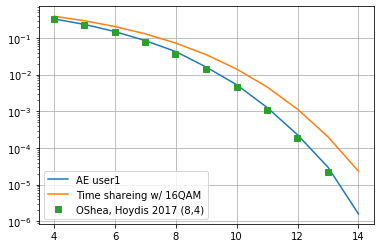

In [13]:
SER_16QAM = np.array([0.394764002072174,   0.297284336602181 ,  0.206748434994456,\
                      0.130364530894198,   0.072921505882596,   0.035247490570099,  \
   0.014252925333135, 0.004627995262115,   0.001144954720374, \
   0.000201748105359,   0.000023232446886])    
    

plt.semilogy(SNR_arr, SER1, label='AE user1')
plt.semilogy(SNR_arr, SER_16QAM, label='Time shareing w/ 16QAM ')
plt.semilogy(OShea_AE84[:,0], OShea_AE84[:,1], marker='s', linestyle='None', label='OShea, Hoydis 2017 (8,4)')



plt.legend()
plt.grid(True)
    
    

In [14]:
class Rotation(nn.Module):
    def __init__(self):
        super().__init__()    
        self.theta = nn.ParameterList()
        for i in range(N):
            for j in range(i+1,N):
                tmp = nn.Parameter(np.pi*2*torch.rand(size =(1,))) 
                self.theta.append(tmp)
        
            
    def forward(self,x1, x2):    
        tmp=0
        for i in range(N):
            for j in range(i+1,N):
                
                ### Define Givens matrix
                R = torch.zeros(8,8).float().to(device)
                for k in range(N):
                    R[k][k] = 1
                    R[i][i] = torch.cos(self.theta[tmp])
                    R[j][j] = torch.cos(self.theta[tmp])
                    R[i][j] = -torch.sin(self.theta[tmp])
                    R[j][i] = torch.sin(self.theta[tmp])

                tmp = tmp+1
                x1 = torch.matmul(R, x1)
                x2 = torch.matmul(R, x2)
                
        return x1, x2
               
rotate = Rotation().to(device)
opt_r = Adam(rotate.parameters(), 1e-1)

In [15]:


const1 = encoder1(torch.eye(M).float().to(device))
const2 = encoder2(torch.eye(M).float().to(device))

gradient_steps = 200
t = tqdm(range(len(range(gradient_steps))), desc="epoch")
loss_sv = []
for I in t:
    X1 = torch.transpose(const1, 1,0) # NxM
    X2 = torch.transpose(const2, 1,0)
   
    X1, X2 = rotate(X1, X2)
    
    X1 = X1[0:N//2,:]
    X2 = X2[N//2:,:]
    
    train_loss = torch.mean(torch.sum(X1**2, 0)) + torch.mean(torch.sum(X2**2, 0))

    opt_r.zero_grad()
    train_loss.backward(retain_graph=True )
    opt_r.step()
    loss_sv.append(train_loss.item())
    
    t.set_description("loss={:.1f}".format(train_loss))
    


loss=0.0: 100%|██████████| 200/200 [00:27<00:00,  7.16it/s]


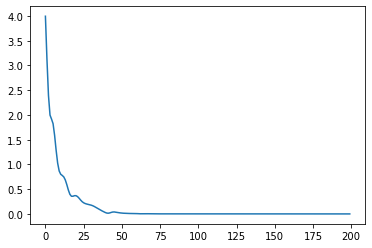

In [16]:
plt.plot(loss_sv)

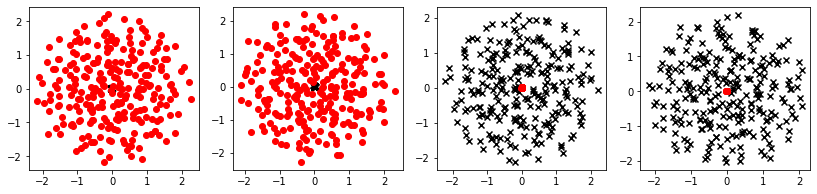

In [17]:
X1 = torch.transpose(const1, 1,0) # NxM
X2 = torch.transpose(const2, 1,0)



X1, X2 = rotate(X1, X2)
X1 =  torch.transpose(X1, 1,0) # M x N
X2 =  torch.transpose(X2, 1,0) 

xx1 = X1.to('cpu').detach().numpy()
xx2 = X2.to('cpu').detach().numpy()


fig, axs = plt.subplots(1, 4, figsize=(4*3+2,3))
ax1 = axs[0]
ax2 = axs[1]
ax3 = axs[2]
ax4 = axs[3]



ax1.scatter(xx1[:,0],xx1[:,1], c='k', marker='x')    
ax2.scatter(xx1[:,2],xx1[:,3], c='k', marker='x')
ax3.scatter(xx1[:,4],xx1[:,5], c='k', marker='x')
ax4.scatter(xx1[:,6],xx1[:,7], c='k', marker='x')


ax1.scatter(xx2[:,0],xx2[:,1], c='red',  marker='o')    
ax2.scatter(xx2[:,2],xx2[:,3], c='red',  marker='o')
ax3.scatter(xx2[:,4],xx2[:,5], c='red',  marker='o')
ax4.scatter(xx2[:,6],xx2[:,7], c='red',  marker='o')
